# Load Data

In [12]:
# import packages
import pandas as pd
import datetime as dt
import numpy as np
import re 
import matplotlib.pyplot as plt
import seaborn as sns

from textblob import TextBlob
from collections import Counter

import contractions

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

from nltk.corpus import stopwords, words, wordnet
from nltk.util import ngrams
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer
from nltk import ngrams
from nltk.tokenize import word_tokenize

from gensim import corpora
from gensim.models.ldamodel import LdaModel

from sklearn.feature_extraction.text import TfidfVectorizer

custom_colors = {'positive': '#87EBA8', 'neutral': '#909090', 'negative': '#F28268'}    # Green ; Gray ; Red 

[nltk_data] Downloading package stopwords to C:\Users\York
[nltk_data]     Yong\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\York
[nltk_data]     Yong\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\York
[nltk_data]     Yong\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [6]:
df = pd.read_excel("../data/mcdonalds_neutral_reviews.xlsx")
#remove spaces in column names
df.columns = df.columns.str.strip()
df.head()

,reviewer_id,store_name,category,store_address,latitude,longitude,Average of rating_count,review_time,review,rating,actual_sentiment,service,cleanliness,food,price,others
0,19,McDonald's,Fast food restaurant,"1044 US-11, Champlain, NY 12919, United States",44.981410,-73.459820,1306,7 months ago,The pricing is fair for what you get.,3 stars,neutral,0,0,0,2,0
1,20,McDonald's,Fast food restaurant,"10451 Santa Monica Blvd, Los Angeles, CA 90025...",34.056593,-118.426000,2251,7 months ago,Prices are standard for a fast food place.,3 stars,neutral,0,0,0,2,0
2,21,McDonald's,Fast food restaurant,"10901 Riverside Dr, North Hollywood, CA 91602,...",34.152507,-118.367904,1794,10 months ago,The price is reasonable considering it's fast ...,3 stars,neutral,0,0,0,2,0
3,24,McDonald's,Fast food restaurant,"1100 N US Hwy 377, Roanoke, TX 76262, United S...",33.009318,-97.222925,998,8 months ago,"Prices were neither too high nor too low, just...",3 stars,neutral,0,0,0,2,0
4,32,McDonald's,Fast food restaurant,"111 Madison St, Oak Park, IL 60302, United States",41.879656,-87.777913,1454,9 months ago,I felt that the price was neither cheap nor ex...,3 stars,neutral,0,0,0,2,0


<a name="missing-data"></a>
## 3.1 Handling Missing Data
Handle any missing or null entries in the dataset, either by removing them or imputing with appropriate values.

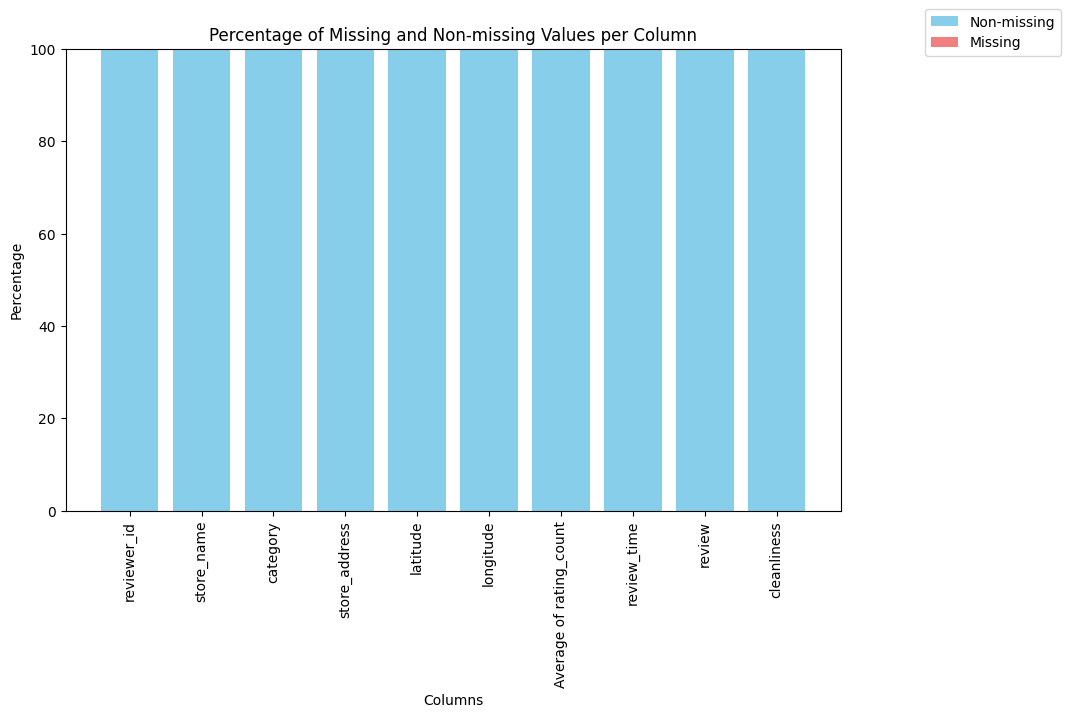

In [7]:
def plot_missing_data(df):
    #  the proportion of missing and non-missing values per column
    missing_df = df.iloc[:, list(range(0, 9)) + [12]]
    missing_percentage = missing_df.isnull().mean() * 100
    non_missing_percentage = 100 - missing_percentage

    # Create a DataFrame for plotting
    missing_data = pd.DataFrame({
        'Missing': missing_percentage,
        'Non-missing': non_missing_percentage
    })

    # Plot the 100% stacked bar chart
    fig, ax = plt.subplots(figsize=(10, 6))
    # Plot non-missing values
    ax.bar(missing_data.index, missing_data['Non-missing'], label='Non-missing', color='skyblue')
    # Plot missing values on top of non-missing values
    ax.bar(missing_data.index, missing_data['Missing'], bottom=missing_data['Non-missing'], label='Missing', color='lightcoral')

    # Add labels and title
    plt.xticks(rotation=90)
    plt.xlabel('Columns')
    plt.ylabel('Percentage')
    plt.title('Percentage of Missing and Non-missing Values per Column')
    plt.legend(bbox_to_anchor=(1.1, 1.1))

    # Show plot
    plt.show()

plot_missing_data(df)

<a name="text-cleaning"></a>
## 3.2 Text Cleaning
- Convert text to lowercase to eliminate case-sensitivity issues.
- Expand contractions (e.g., "can't" to "cannot") to standardize the text.
- Remove special characters, numbers, and punctuation that do not contribute to the overall meaning of the text.

In [13]:
# Function for text cleaning
def clean_text(text):
   
    # Expand contractions
    text = contractions.fix(text)
    
    # Convert text to lowercase
    text = text.lower()
    
    # Remove special characters, numbers, and punctuation
    text = re.sub(r"[^a-zA-Z\s']", '', text)
    
    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Apply the cleaning function to the 'review' column
df['cleaned_review'] = df['review'].apply(clean_text)

# Display the first few rows of the updated DataFrame
df[['review', 'cleaned_review']].head()

,review,cleaned_review
0,The pricing is fair for what you get.,the pricing is fair for what you get
1,Prices are standard for a fast food place.,prices are standard for a fast food place
2,The price is reasonable considering it's fast ...,the price is reasonable considering it is fast...
3,"Prices were neither too high nor too low, just...",prices were neither too high nor too low just ...
4,I felt that the price was neither cheap nor ex...,i felt that the price was neither cheap nor ex...


<a name="tokenization"></a>
## 3.3 Tokenization
Process of splitting the text into individual words or tokens which is an essential step before any further operations like stop word removal, stemming, or lemmatization, because the text needs to be in smaller units prior to processing it.

In [14]:
# Tokenize the text (split into individual words)
def tokenize_text(text):
    return text.split() 

# Apply tokenization
df['tokenized_review'] = df['cleaned_review'].apply(tokenize_text)

# Display tokenized reviews
df[['cleaned_review', 'tokenized_review']].head()

,cleaned_review,tokenized_review
0,the pricing is fair for what you get,"[the, pricing, is, fair, for, what, you, get]"
1,prices are standard for a fast food place,"[prices, are, standard, for, a, fast, food, pl..."
2,the price is reasonable considering it is fast...,"[the, price, is, reasonable, considering, it, ..."
3,prices were neither too high nor too low just ...,"[prices, were, neither, too, high, nor, too, l..."
4,i felt that the price was neither cheap nor ex...,"[i, felt, that, the, price, was, neither, chea..."


<a name="stop-words-removal"></a>
## 3.4 Stop Words Removal
Eliminate common words (such as "the", "and", "is") that do not contribute significantly to the meaning of the text. Removing them reduces the noise in the data.

In [15]:
# Get English stop words
stop_words_final = set(stopwords.words('english'))

# Add more common words to the stopwords list
stop_words_final.update(['food', 'mcdonald', 'mcdonalds','order', 'location', "mcdonald's"])  

# View stop words
stop_words_list = list(stop_words_final)[:50]
print(f"These are the first 50 stopwords: {stop_words_list}")

These are the first 50 stopwords: ['below', 's', 'theirs', 'was', 'hasn', 'such', 'it', 'themselves', 'we', 'itself', 'they', 'nor', "haven't", "should've", "you've", "hadn't", 'm', 'why', 'here', 'mustn', 'our', 'mcdonalds', 'her', 'herself', 'on', 'his', 'll', 'wasn', 'most', 'so', "don't", 'again', 'up', 'few', 'or', 'haven', 'mcdonald', 'ourselves', 'yourself', 'are', 'y', "couldn't", 'very', 'between', 'shouldn', 'be', 'ours', 'as', 'for', "she's"]


In [16]:
# Function to remove stop words
def remove_stop_words(tokens):
    return [word for word in tokens if word.lower() not in stop_words_final]

# Apply stop word removal
df['filtered_review'] = df['tokenized_review'].apply(remove_stop_words)

# Display the reviews after stop words removal
df[['tokenized_review', 'filtered_review']].head()

,tokenized_review,filtered_review
0,"[the, pricing, is, fair, for, what, you, get]","[pricing, fair, get]"
1,"[prices, are, standard, for, a, fast, food, pl...","[prices, standard, fast, place]"
2,"[the, price, is, reasonable, considering, it, ...","[price, reasonable, considering, fast]"
3,"[prices, were, neither, too, high, nor, too, l...","[prices, neither, high, low, fine]"
4,"[i, felt, that, the, price, was, neither, chea...","[felt, price, neither, cheap, expensive]"


<a name="lemmatization"></a>
## 3.5 Lemmatization
Lemmatization is a more advanced process that reduces words to their dictionary form, ensuring the correct base form (e.g., "better" becomes "good").   

In the case of McDonald's reviews, we chose to only use Lemmatization due to the following reasons: 

**Accuracy and Context:**   
Reviews often contain a wide range of vocabulary, including both formal and informal language, and may feature irregular words (e.g., "better", "best", "good"). Lemmatization takes the context of words into account, ensuring that words are reduced to their meaningful base form.   

**Sentiment Analysis:**   
Lemmatization helps by preserving the intended meaning of words.   
For example, in a review like "The fries were better today", lemmatization will reduce "better" to "good", whereas stemming might not recognize the positive sentiment as accurately.

**Handling Complex Words:**
Reviews often include various verb tenses, plural forms, and comparative adjectives, which lemmatization can handle effectively, e.g. "Running" → "Run"   
Stemming, on the other hand, might reduce "running" to "runn", or fail to correctly identify more complex forms.   

**Real Words for Reporting:**   
When performing analysis on reviews, it’s often important to present findings using real, recognizable words. Lemmatization always returns dictionary-based words, whereas stemming can produce non-standard root forms that may not make sense in reports or visualizations.   

In [17]:
# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Example function for lemmatization
def lemmatize_text(tokens):
    return [lemmatizer.lemmatize(token) for token in tokens]

df['lemmatized_review'] = df['filtered_review'].apply(lemmatize_text)

# Display the reviews after stemming and lemmatization
df[['filtered_review', 'lemmatized_review']].head()

,filtered_review,lemmatized_review
0,"[pricing, fair, get]","[pricing, fair, get]"
1,"[prices, standard, fast, place]","[price, standard, fast, place]"
2,"[price, reasonable, considering, fast]","[price, reasonable, considering, fast]"
3,"[prices, neither, high, low, fine]","[price, neither, high, low, fine]"
4,"[felt, price, neither, cheap, expensive]","[felt, price, neither, cheap, expensive]"


<a name="vectorization"></a>
## 3.6 Vectorization
To convert the text into a numerical format that machine learning models can understand.    
Vectorization transforms the text into numbers. In our case, we have chosen to use TF-IDF (Term Frequency-Inverse Document Frequency) due to the following reasons:


**Focus on Important Words:**
TF-IDF assigns higher weight to words that are frequent in a single document (review) but less frequent across the entire collection of reviews. This is important because common words like "the", "food", "order" etc. might appear in many reviews and carry less importance in distinguishing between reviews.   

**Reducing the Impact of Common Words:**
TF-IDF counteracts this by giving less weight to common words, allowing the model to focus on terms that help differentiate the reviews.

**Sparse Data Handling:**
Reviews often contain a large number of words, but each individual review only uses a subset of these words. TF-IDF creates a sparse matrix where most values are zero (i.e., the word does not appear in the review), and it efficiently handles this sparse data.

In [19]:
# Combine tokens back into a string for vectorization
df['token_review_clean'] = df['lemmatized_review'].apply(lambda x: ' '.join(x))

# Initialize TF-IDF Vectorizer
vectorizer = TfidfVectorizer()

# Apply vectorization
tfidf_matrix = vectorizer.fit_transform(df['token_review_clean'])

# Convert the TF-IDF matrix to a DataFrame (optional, to visualize the numerical representation)
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

tfidf_df

,acceptable,accepted,accessible,according,add,addition,advertised,alright,apple,application,...,windowsill,wing,wiped,wood,wore,worst,would,wrap,wrapped,yellow
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,0.0,0.0,0.0,0.0,0.0,0.0,0.428048,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
246,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
247,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
248,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<a name="feature-engineering"></a>
# 4. Feature Engineering
This section outlines the additional features we added to support our analysis.

## 4.1 Location

In [20]:
postal_code_pattern = r'\b[A-Z]{2}\s(\d{5})\b' # 2 letters and 5 digits 
                                               # Requires the 2 letters first so addresses that start with 5 digits 
                                               # are not picked up

# Function to extract postal code from the store address
def extract_postal_code(address):
    match = re.search(postal_code_pattern, address)
    return match.group(1) if match else None

# Apply the function to the 'store_address' column and create a new 'location' column
df.loc[:, 'location'] = df['store_address'].apply(extract_postal_code)

In [21]:
# Generate a Store ID based on the unique store_address, starting from 1
df.loc[:, 'store_id'] = pd.factorize(df['store_address'])[0] + 1

# Display the DataFrame with the new Store ID column
df.iloc[:, list(range(0, 9)) + [12]].head()

,reviewer_id,store_name,category,store_address,latitude,longitude,Average of rating_count,review_time,review,cleanliness
0,19,McDonald's,Fast food restaurant,"1044 US-11, Champlain, NY 12919, United States",44.981410,-73.459820,1306,7 months ago,The pricing is fair for what you get.,0
1,20,McDonald's,Fast food restaurant,"10451 Santa Monica Blvd, Los Angeles, CA 90025...",34.056593,-118.426000,2251,7 months ago,Prices are standard for a fast food place.,0
2,21,McDonald's,Fast food restaurant,"10901 Riverside Dr, North Hollywood, CA 91602,...",34.152507,-118.367904,1794,10 months ago,The price is reasonable considering it's fast ...,0
3,24,McDonald's,Fast food restaurant,"1100 N US Hwy 377, Roanoke, TX 76262, United S...",33.009318,-97.222925,998,8 months ago,"Prices were neither too high nor too low, just...",0
4,32,McDonald's,Fast food restaurant,"111 Madison St, Oak Park, IL 60302, United States",41.879656,-87.777913,1454,9 months ago,I felt that the price was neither cheap nor ex...,0


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   reviewer_id              250 non-null    int64  
 1   store_name               250 non-null    object 
 2   category                 250 non-null    object 
 3   store_address            250 non-null    object 
 4   latitude                 250 non-null    float64
 5   longitude                250 non-null    float64
 6   Average of rating_count  250 non-null    int64  
 7   review_time              250 non-null    object 
 8   review                   250 non-null    object 
 9   rating                   250 non-null    object 
 10  actual_sentiment         250 non-null    object 
 11  service                  250 non-null    int64  
 12  cleanliness              250 non-null    int64  
 13  food                     250 non-null    int64  
 14  price                    2

<a name="final-dataset"></a>
<br><br>
# 5. Final Dataset

In [24]:
final_df = df[['store_address', 'location', 'reviewer_id', 'review_time','actual_sentiment',
                'review', 'token_review_clean','service','cleanliness','food','price','others']]

final_df = final_df.sort_values(by=['location', 'actual_sentiment'])

final_df = final_df.drop_duplicates(subset=['store_address', 'review_time', 'actual_sentiment','review'])

final_df.head()

,store_address,location,reviewer_id,review_time,actual_sentiment,review,token_review_clean,service,cleanliness,food,price,others
27,"621 Broadway, Newark, NJ 07104, United States",07104,306,9 months ago,neutral,"Prices were as expected for fast food, no surp...",price expected fast surprise,0,0,0,2,0
63,"621 Broadway, Newark, NJ 07104, United States",07104,851,9 months ago,neutral,The self-service drink station was functioning,selfservice drink station functioning,0,2,0,0,0
99,"621 Broadway, Newark, NJ 07104, United States",07104,1663,9 months ago,neutral,The main counter had a laminate surface,main counter laminate surface,0,2,0,0,0
135,"621 Broadway, Newark, NJ 07104, United States",07104,1978,8 months ago,neutral,The cashier asked if the customer wanted to ad...,cashier asked customer wanted add item,2,0,0,0,0
171,"621 Broadway, Newark, NJ 07104, United States",07104,2759,8 months ago,neutral,Sundaes were topped with chocolate or caramel ...,sundae topped chocolate caramel sauce,0,0,2,0,0


In [25]:
# Set display option to show full text
pd.set_option('display.max_colwidth', None)

final_df.loc[[185,187], :]

,store_address,location,reviewer_id,review_time,actual_sentiment,review,token_review_clean,service,cleanliness,food,price,others
185,"1100 N US Hwy 377, Roanoke, TX 76262, United States",76262,2904,10 months ago,neutral,"The McRib was a boneless pork patty shaped like ribs, served with BBQ sauce and onions",mcrib boneless pork patty shaped like rib served bbq sauce onion,0,0,2,0,0
187,"1121 Garnet Ave, San Diego, CA 92109, United States",92109,2906,11 months ago,neutral,"The Bacon Ranch Salad included mixed greens, bacon pieces, and ranch dressing",bacon ranch salad included mixed green bacon piece ranch dressing,0,0,2,0,0


In [26]:
final_df.isna().value_counts()

store_address  location  reviewer_id  review_time  actual_sentiment  review  token_review_clean  service  cleanliness  food   price  others
False          False     False        False        False             False   False               False    False        False  False  False     250
Name: count, dtype: int64

In [27]:
print(f"The final dataset contains {len(final_df)} rows and {len(final_df.columns)} columns.")

The final dataset contains 250 rows and 12 columns.


In [29]:
final_df.to_csv('../data/cleaned_data_additional.csv')